<a href="https://colab.research.google.com/github/daniel-falk/ai-ml-principles-exercises/blob/main/ML-inference/autoML/edge_impulse_infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example shows how to run deep learning models for object detection trained in Edge Impulse.

# Train your model
First you need to train a model to detect the kind of objects you want to. You can follow [the guide from Edge Impulse](https://docs.edgeimpulse.com/docs/tutorials/object-detection).

# Download your model
Once the model is trained you should go to the "Deployment" tab and search for "Linux (x86)" in the field "Search deployment options". After selecting the target, press "Build" to convert the model. The download will start once the model is converted.

# Load the model
This should result in a model with the *.eim* suffix. Upload the model to the Colab notebook. The downloaded model is an executable file. The executable file implenments a communication protocol, which we can see if we try to execute it (these two lines are not needed, they are here only to show that it is an Linux executable):

In [ ]:
!chmod +x faces-linux-x86_64-v2.eim
!./faces-linux-x86_64-v2.eim

Download an image that we can use to detect faces and load it using the Pillow library.

In [ ]:
!wget https://assets.weforum.org/article/image/XaHpf_z51huQS_JPHs-jkPhBp0dLlxFJwt-sPLpGJB0.jpg -O faces.jpg

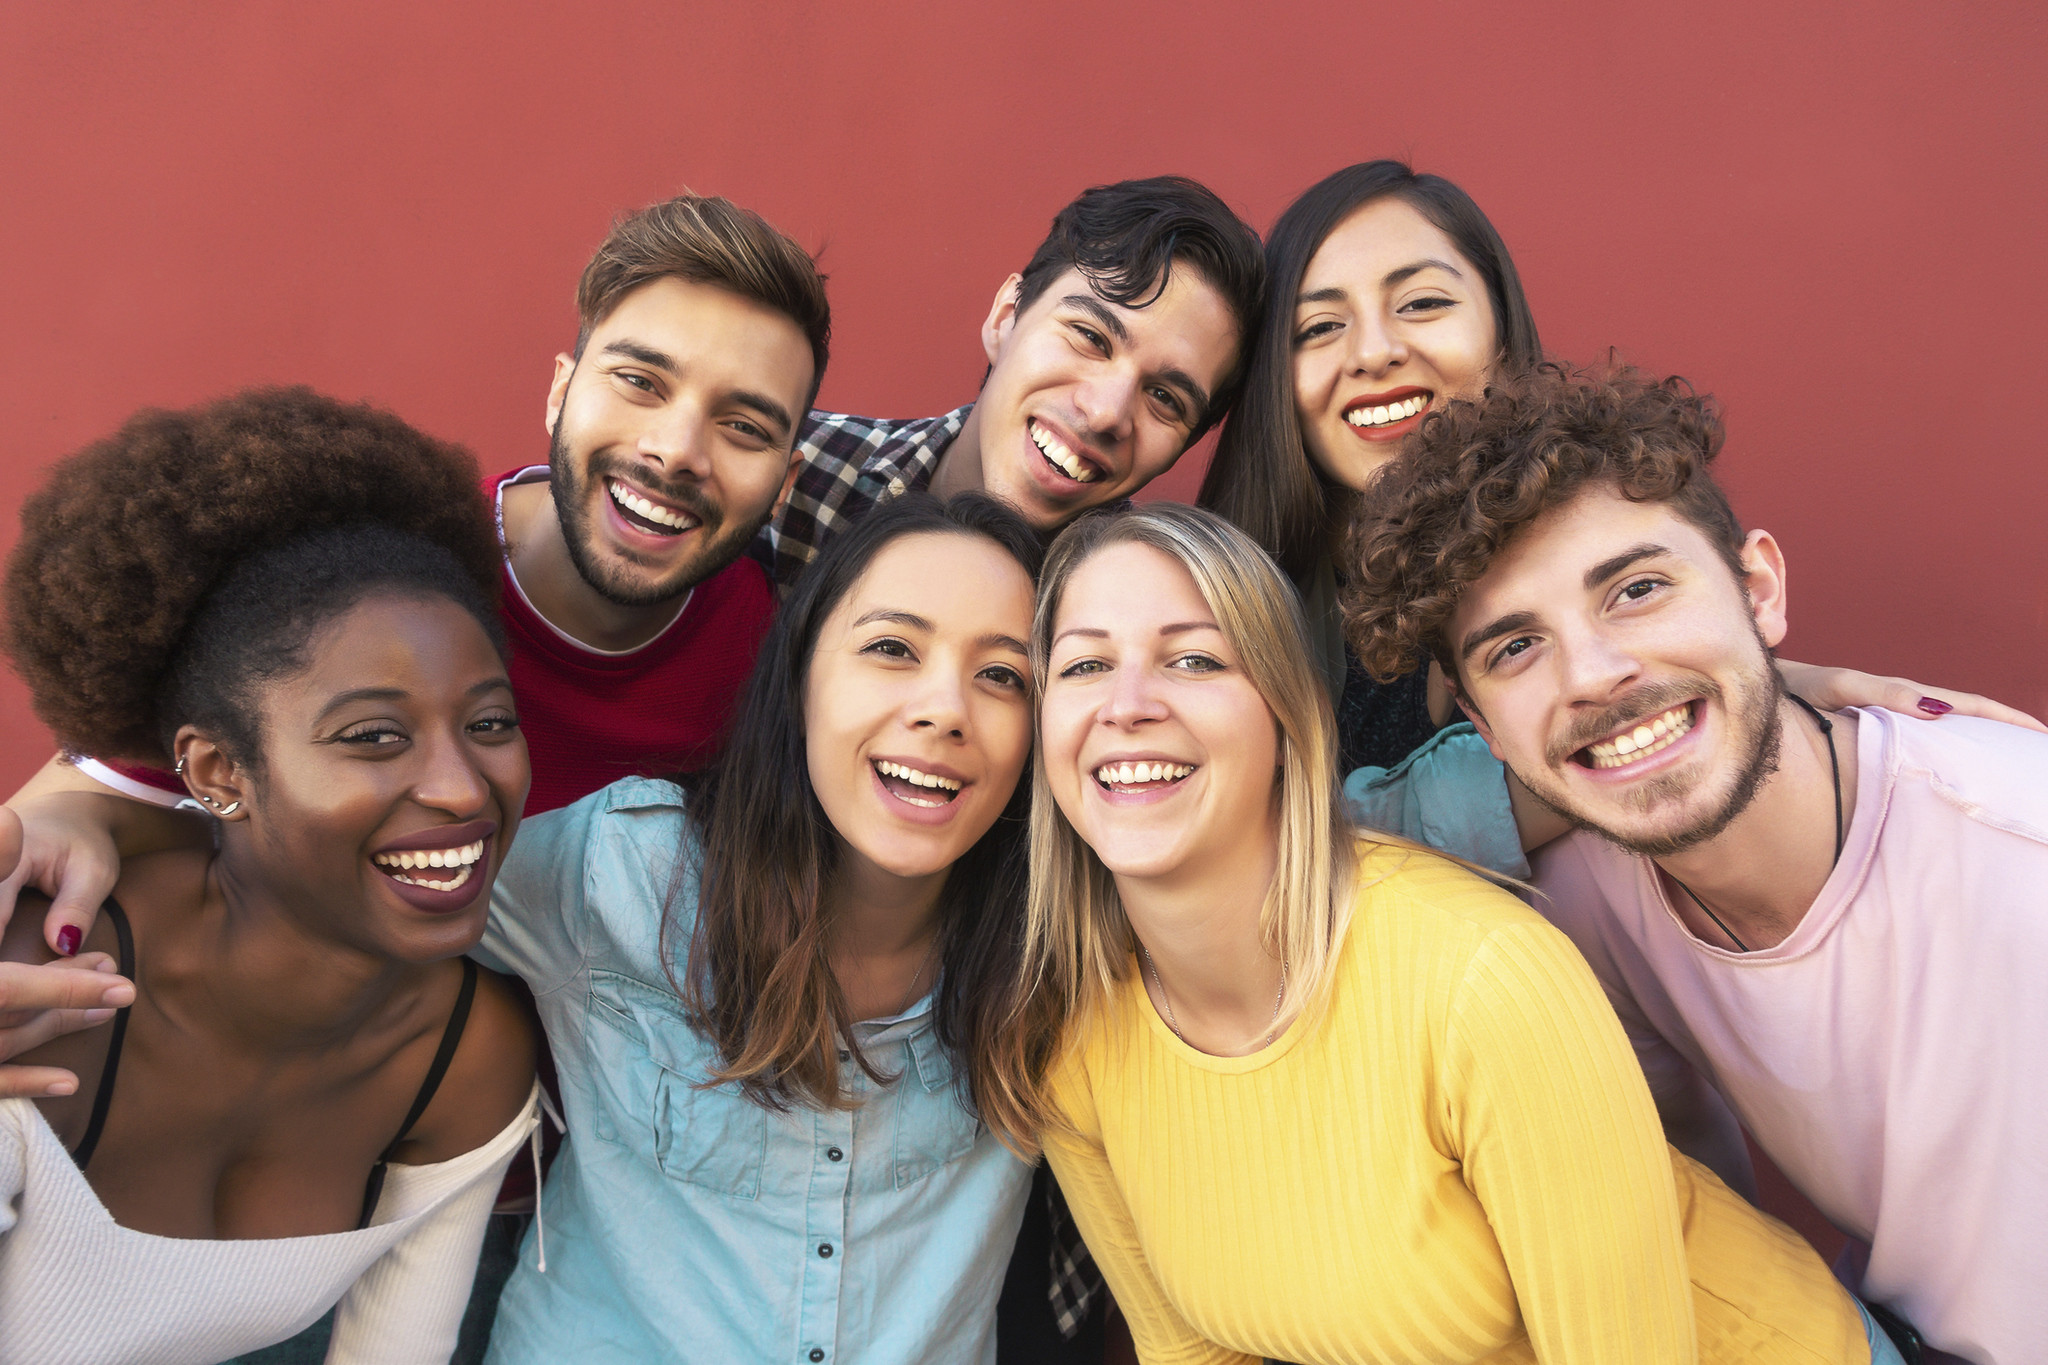

In [56]:
from PIL import Image

pil_image = Image.open("faces.jpg")
pil_image

In [50]:
import numpy as np

image = np.asarray(pil_image)

# Install Edge Impulse
The Edge Impulse Python library is used to run the model inference from Python. We need to first install it.

In [51]:
!pip install edge_impulse_linux

# For some reason pyaudio is a dependency to use the image processing in edge impulse
# since the edge impulse framework also support audio models.
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pyaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
^C
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Infer on image
Next we can use the Python SDK to run the model inference. Edge Impulse supports multiple media types, images is one of them. We use the Image Impulse Runner class which uses starts the executable binary and communicates with it.

Starting the runtime takes a lot of time, so if we would have multiple images we could use the same runner to infer all frames. In this example we only have one image, so we start the runner and run the inference on the image, then we stop the runner.

The runner preprocessing (`runner.get_features_from_image`) runs all the preprocessing as it was defined in the Edge Impulse framework when training the model. This preprocessing includes scaling and cropping. The preprocessing function return both the binary features after preprocessing, but also a numpy representation of the preprocessed frame (which we later will use for visualization of the detections).

In [60]:
from edge_impulse_linux.image import ImageImpulseRunner

modelfile = "/content/faces-linux-x86_64-v2.eim"

with ImageImpulseRunner(modelfile) as runner:
  try:
    model_info = runner.init()
    print('Loaded runner for "' + model_info['project']['owner'] + ' / ' + model_info['project']['name'] + '"')

    features, cropped = runner.get_features_from_image(image)
    res = runner.classify(features)
  finally:
    runner.stop()

print(f"Found {len(res['result']['bounding_boxes'])} objects")

Loaded runner for "Daniel / faces"
Found 2 objects


Print a list of detected objects and draw the bounding boxes in the preprocessed frame.

The name of the labels are taken from the model as they are specified when annotating the data that the model was trained on.

In [70]:
import cv2

if "bounding_boxes" in res["result"].keys():
  print(f"Preprocessing took {res['timing']['dsp']} mS and inference {res['timing']['classification']} mS")
  for bb in res["result"]["bounding_boxes"]:
    print(f"Found {bb['label']} with confidence {bb['value']:.2f} at pos={bb['x']},{bb['y']} and size={bb['width']},{bb['height']}")
    x1 = bb["x"] - bb["width"] // 2
    y1 = bb["y"] - bb["height"] // 2
    x2 = bb["x"] + bb["width"] // 2
    y2 = bb["y"] + bb["height"] // 2
    cv2.rectangle(cropped, (x1, y1), (x2, y2), (255, 0, 0), 3)

Preprocessing took 0 mS and inference 1 mS
Found face with confidence 0.86 at pos=64,16 and size=8,8
Found face with confidence 0.52 at pos=40,48 and size=8,8


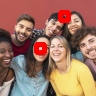

In [59]:
Image.fromarray(cropped)